# Binary Classification with a Software Defects Dataset


## 0) Intro -  Objective 


Your Goal: Predict defects in C programs given various various attributes about the code.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## 1) Import of packages

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from sklearn.model_selection import GroupKFold


from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)


import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#!pip install -U seaborn

data/test.csv
data/train.csv


## 1) Load the data and check structure

In [57]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

In [58]:
train_data.head()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [59]:
train_data.shape

(101763, 22)

#### All numerical variables

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

As explained in the original data :https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction
Number of attributes: 22 (5 different lines of code measure,
3 McCabe metrics, 4 base Halstead measures, 8 derived
Halstead measures, a branch-count, and 1 goal field)

Attribute Information:
  1. loc             : numeric % McCabe's line count of code
  2. v(g)            : numeric % McCabe "cyclomatic complexity"
  3. ev(g)           : numeric % McCabe "essential complexity"
  4. iv(g)           : numeric % McCabe "design complexity"
  5. n               : numeric % Halstead total operators + operands
  6. v               : numeric % Halstead "volume"
  7. l               : numeric % Halstead "program length"
  8. d               : numeric % Halstead "difficulty"
  9. i               : numeric % Halstead "intelligence"
 10. e               : numeric % Halstead "effort"
 11. b               : numeric % Halstead 
 12. t               : numeric % Halstead's time estimator
 13. lOCode          : numeric % Halstead's line count
 14. lOComment       : numeric % Halstead's count of lines of comments
 15. lOBlank         : numeric % Halstead's count of blank lines
 16. lOCodeAndComment: numeric
 17. uniq_Op         : numeric % unique operators
 18. uniq_Opnd       : numeric % unique operands
 19. total_Op        : numeric % total operators
 20. total_Opnd      : numeric % total operands
 21: branchCount     : numeric % of the flow graph
 22. defects         : {false,true} % module has/has not one or more  reported defects

 Some of these features are derived from each other. We would usually be able to drop some. However, the synthetic generation process has botched the relationships.

Relationship: t = e / 18. In the original data, the correlation is perfect.

Relationship: l = 1 / d => we can drop l



## 3) Discover and visualize data to gain insights

##### No missing data

In [61]:
train_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [62]:
test_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
dtype: int64

In [63]:
train_data.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


### Plot features distribution

Variables are very skewed, log transformation should be useful to make better predictions

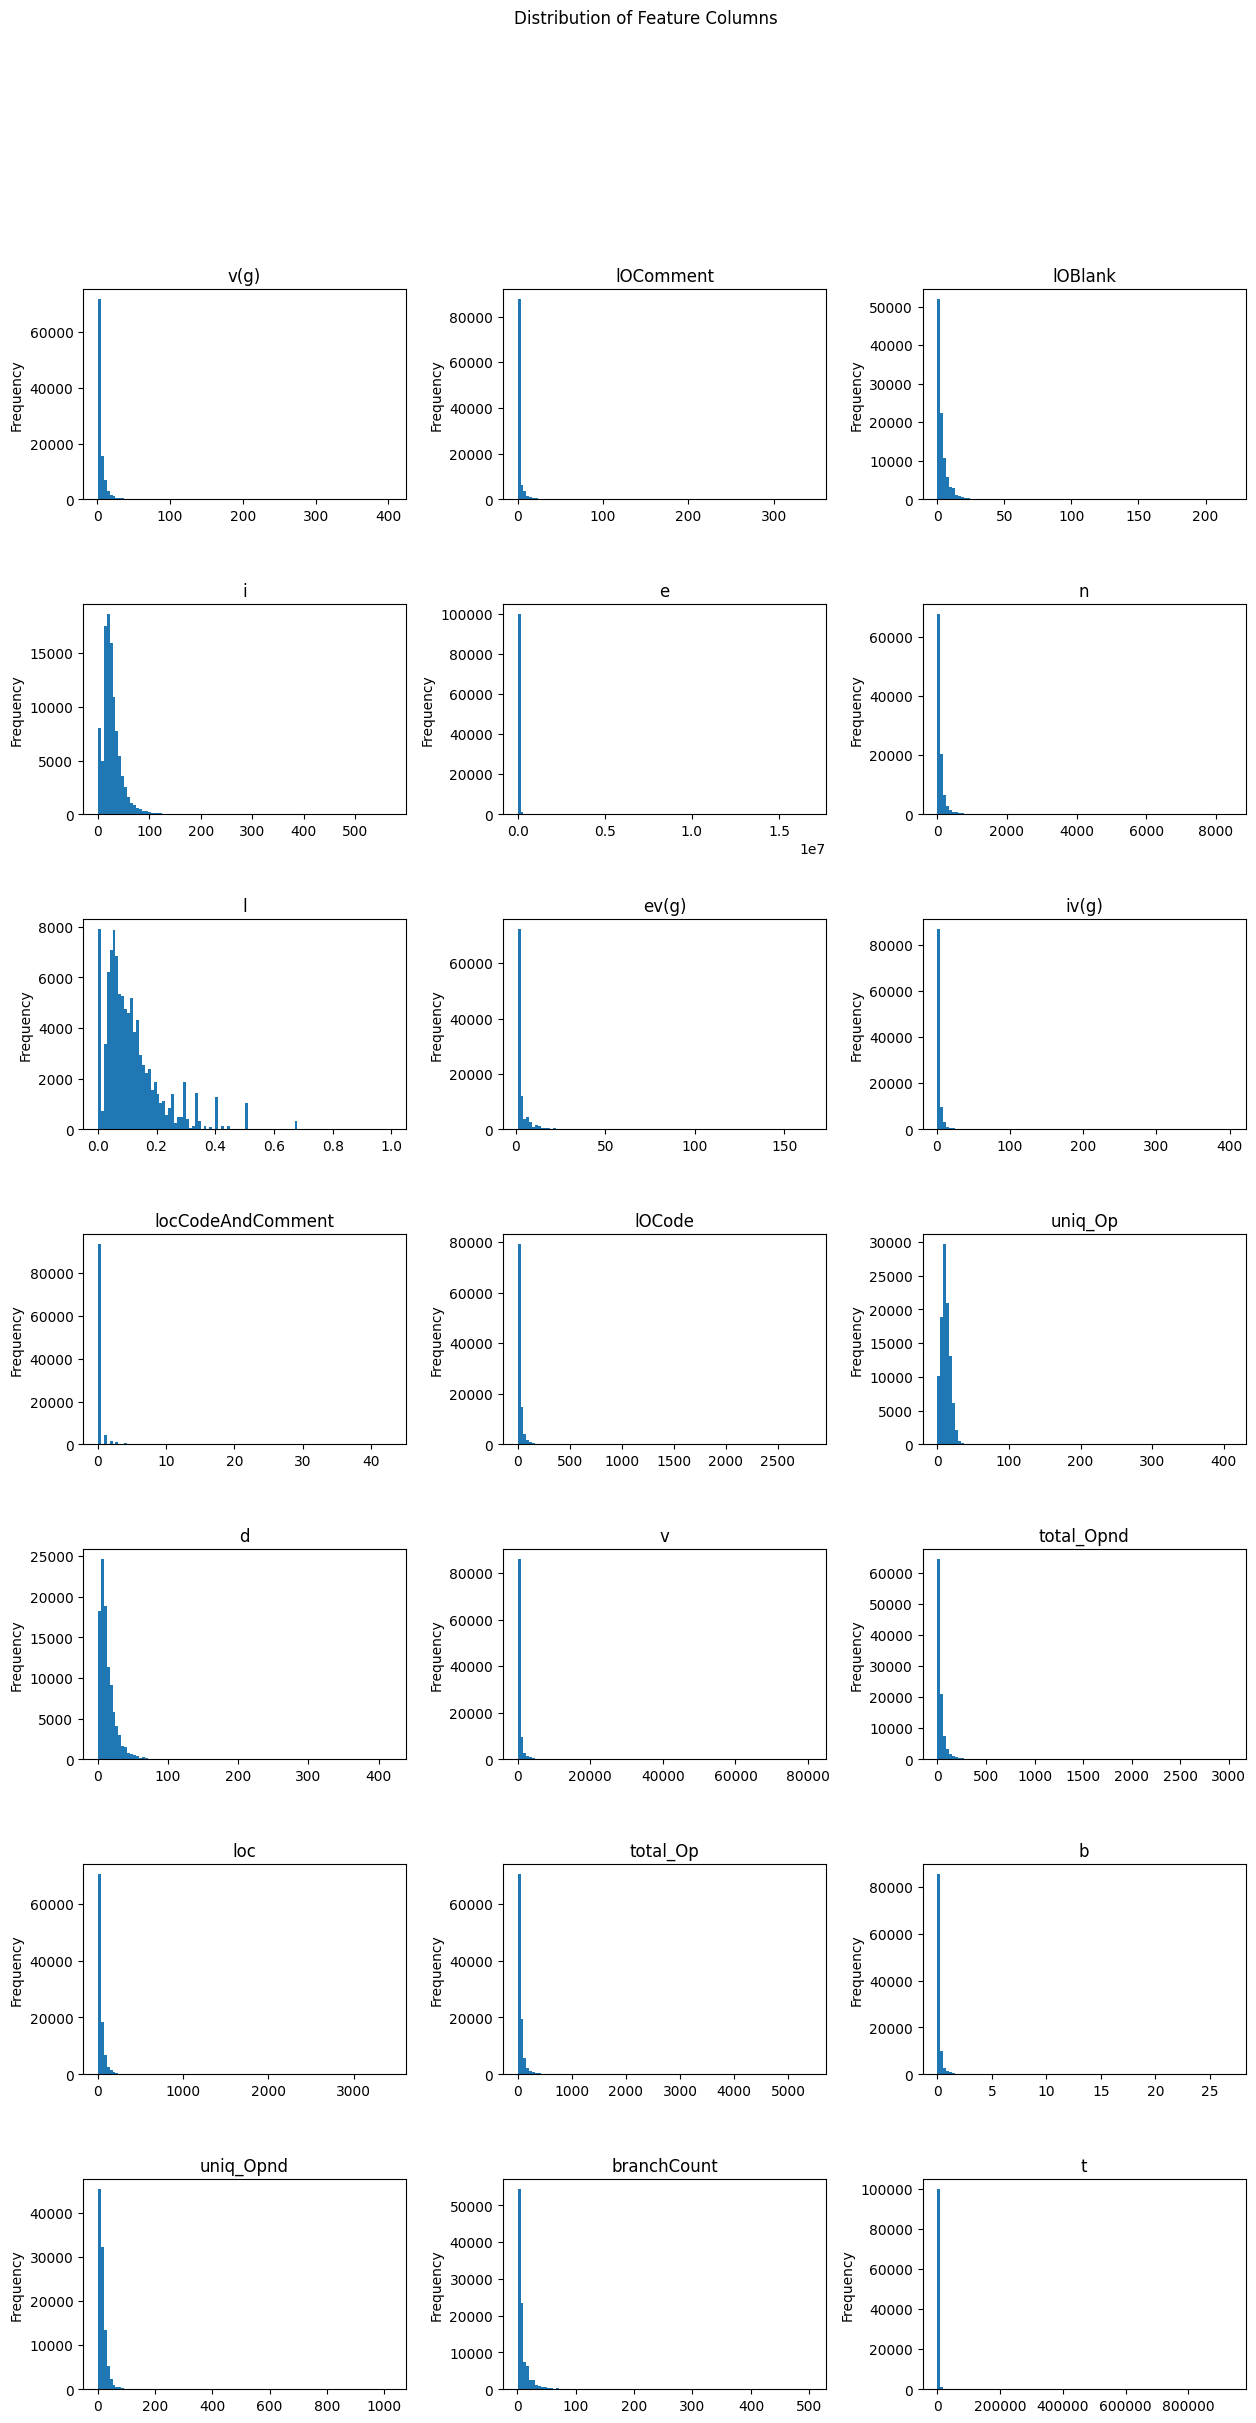

In [79]:
# Get the list of feature columns
feature_columns = set(train_data.columns)-set(["defects"])

# Define the number of rows and columns for subplots
num_rows = (len(feature_columns) + 2) // 3
num_cols = min(len(feature_columns), 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.9, bottom=0.3)

# Iterate through feature columns and plot their distributions
for i, col in enumerate(feature_columns):
    row = i // num_cols
    col_num = i % num_cols
    ax = axes[row, col_num]

    # Plot the distribution
    train_data[col].plot(kind='hist', ax=ax, bins=100, title=col)
    ax.set_ylabel('Frequency')


# Add a title to the overall picture
plt.suptitle("Distribution of Feature Columns")

# Show the plot
plt.show()


## Feature engineering

In [69]:
FEATURES = list(set(train_data.columns)-set(["defects"]))
TARGET = 'defects'

full_data = pd.concat([train_data,test_data])

In [77]:
def edit_features(df):
    
    log_df =  np.log(df[FEATURES]+1)
    log_df[TARGET] = df[TARGET]

    return log_df

full_enhanced=  edit_features(full.copy())
full_enhanced

,v(g),lOComment,lOBlank,i,e,n,l,ev(g),iv(g),locCodeAndComment,...,d,v,total_Opnd,loc,total_Op,b,uniq_Opnd,branchCount,t,defects
id,,,,,,,,,,,,,,,,,,,,,
0,1.386294,0.693147,0.693147,2.724580,8.603332,4.110874,0.058269,0.693147,1.098612,0.0,...,3.023347,5.633467,3.135494,3.135494,3.663562,0.086178,2.302585,1.791759,5.716073,False
1,1.098612,0.000000,0.693147,3.096030,6.843441,3.496508,0.131028,0.693147,1.098612,0.0,...,2.079442,5.025655,2.708050,2.708050,2.944439,0.048790,2.484907,1.386294,3.971046,False
2,1.098612,0.000000,0.693147,3.168003,7.470230,3.828641,0.104360,0.693147,1.098612,0.0,...,2.202765,5.291544,2.890372,2.484907,3.367296,0.067659,2.484907,1.386294,4.589549,False
3,0.693147,0.000000,1.098612,2.937043,6.162599,3.178054,0.173953,0.693147,0.693147,0.0,...,1.832581,4.553982,2.079442,2.197225,2.833213,0.029559,1.945910,0.693147,3.307253,True
4,1.098612,0.000000,1.098612,2.598235,5.904462,2.890372,0.165514,0.693147,1.098612,0.0,...,1.891605,4.126166,2.397895,2.484907,2.397895,0.019803,1.945910,1.386294,3.059176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169600,0.693147,0.000000,2.079442,3.883829,9.061065,4.836282,0.067659,0.693147,0.693147,0.0,...,2.708050,6.488521,4.007333,3.737670,4.276666,0.198851,3.332205,0.693147,6.174515,NaN
169601,1.386294,0.000000,1.386294,3.189653,6.967834,3.663562,0.139762,0.693147,1.386294,0.0,...,2.047693,5.090186,2.772589,3.044522,3.178054,0.048790,2.397895,1.791759,4.093344,NaN
169602,1.098612,0.000000,1.609438,3.320349,7.678326,3.970292,0.104360,0.693147,1.098612,0.0,...,2.302585,5.484797,2.944439,3.218876,3.610918,0.076961,2.833213,1.386294,4.795791,NaN


In [85]:
full_enhanced["v(g)"].describe()

count    169605.000000
mean          1.582688
std           0.688419
min           0.693147
25%           1.098612
50%           1.386294
75%           1.945910
max           6.154858
Name: v(g), dtype: float64

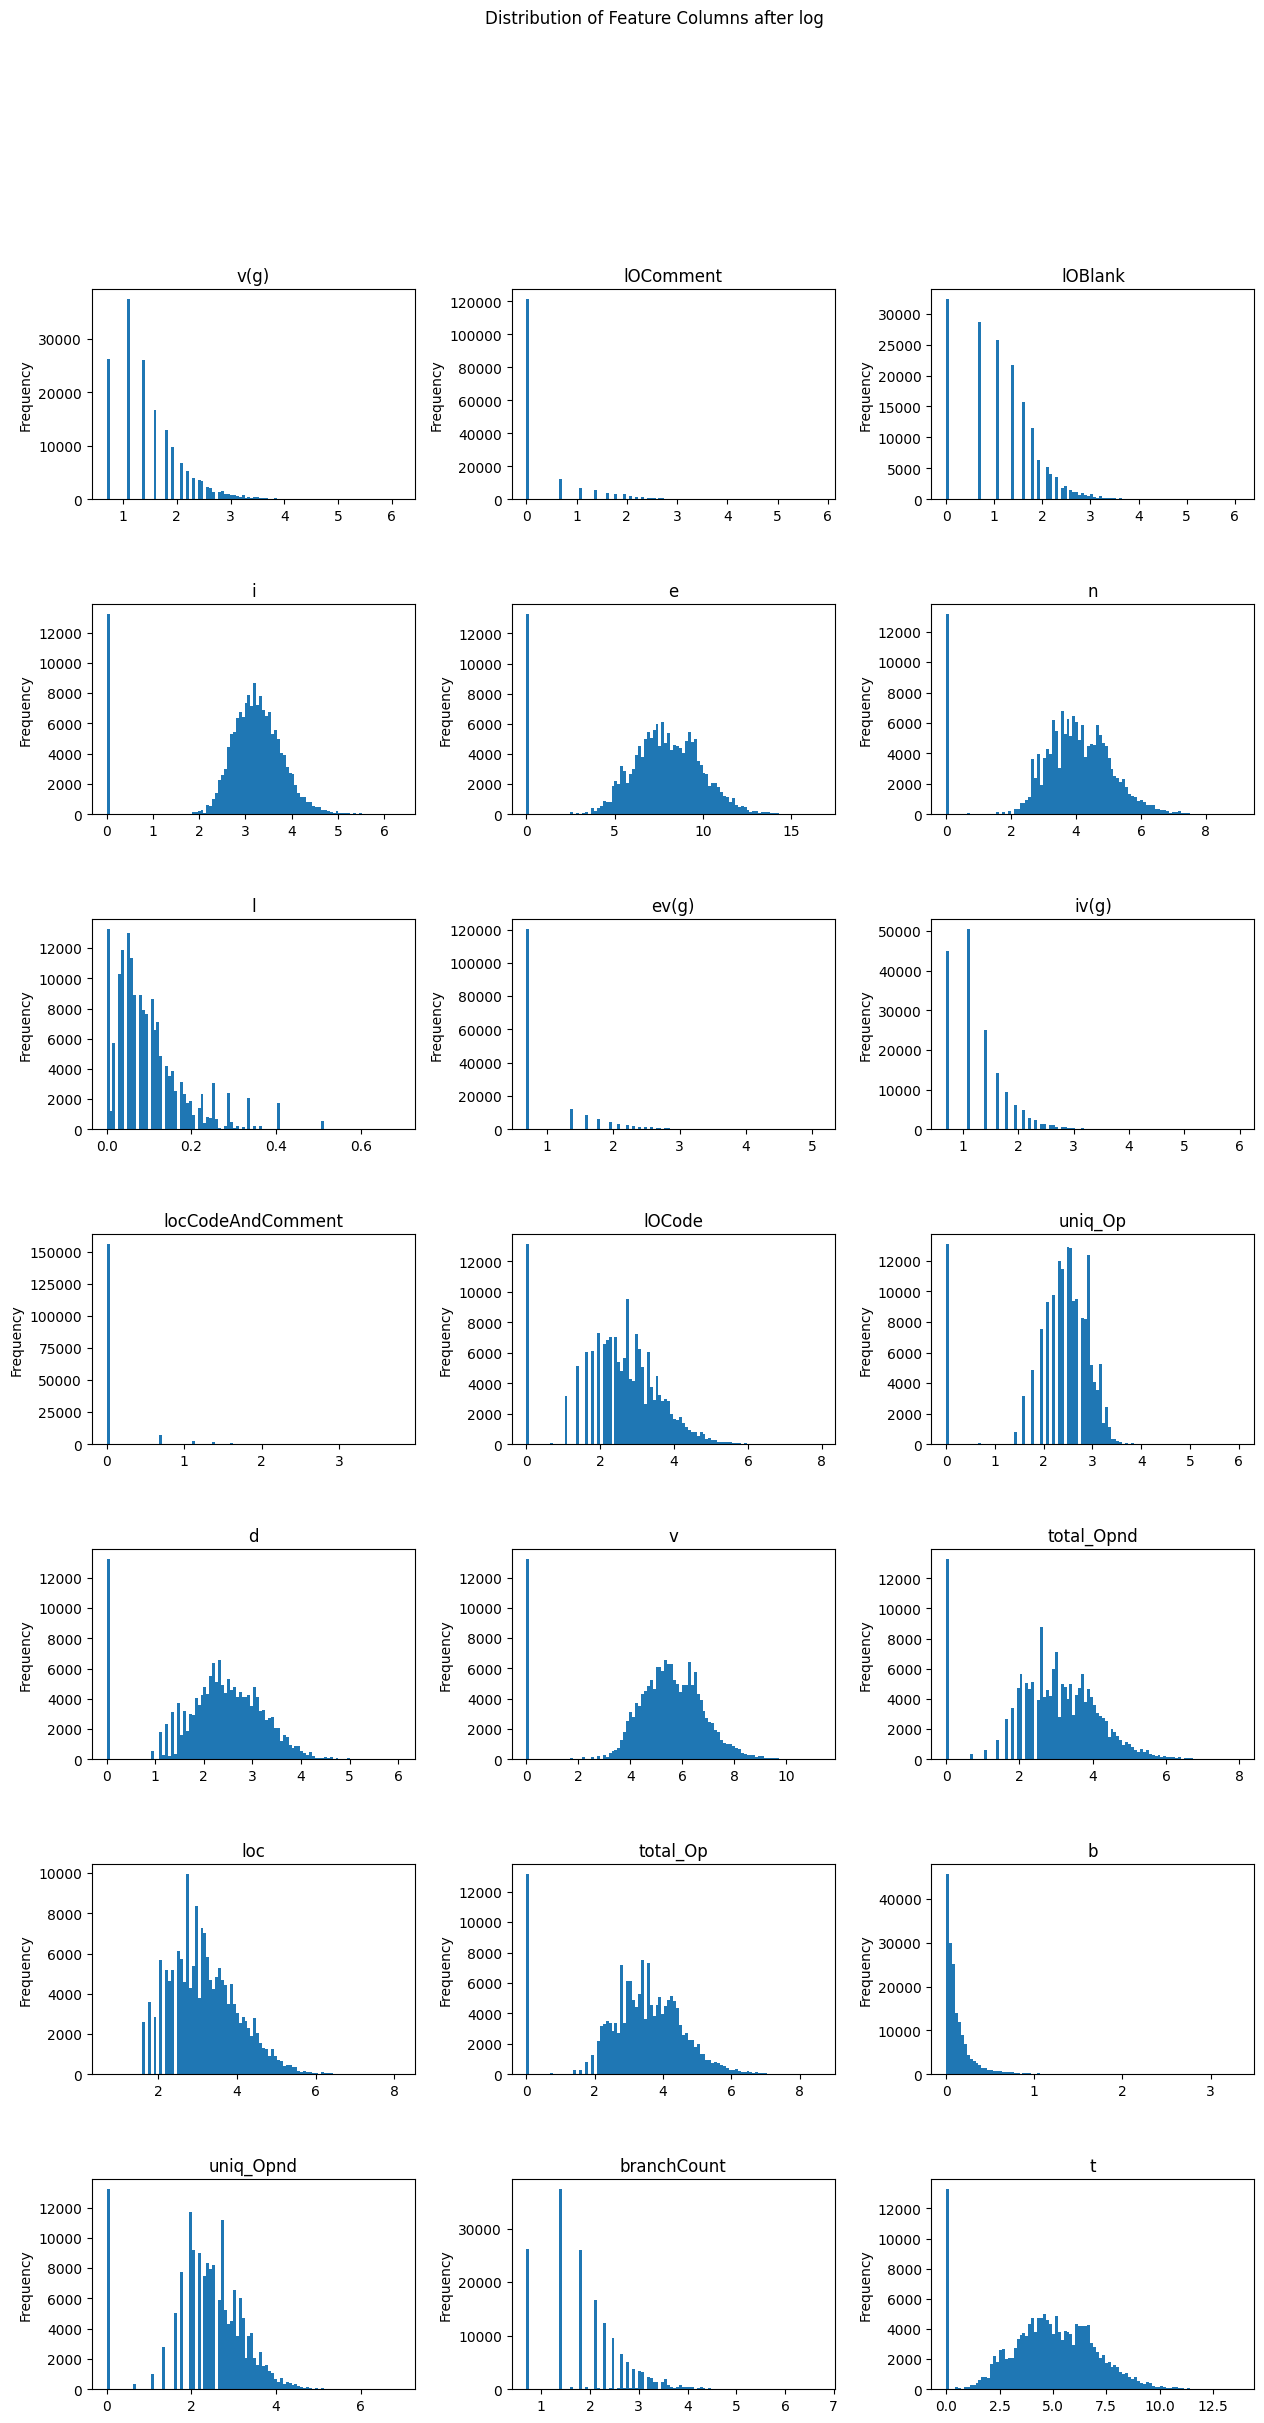

In [78]:
# Get the list of feature columns
feature_columns = set(train_data.columns)-set(["defects"])

# Define the number of rows and columns for subplots
num_rows = (len(feature_columns) + 2) // 3
num_cols = min(len(feature_columns), 3)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.9, bottom=0.3)

# Iterate through feature columns and plot their distributions
for i, col in enumerate(feature_columns):
    row = i // num_cols
    col_num = i % num_cols
    ax = axes[row, col_num]

    # Plot the distribution
    full_enhanced[col].plot(kind='hist', ax=ax, bins=100, title=col)
    ax.set_ylabel('Frequency')


# Add a title to the overall picture
plt.suptitle("Distribution of Feature Columns after log")

# Show the plot
plt.show()


## Predictions
If you're wondering why you have unusually low score, that's because you're using predict method. Try using predict_proba instead. --> Does not seem to work fine



In [90]:
from sklearn.linear_model import LogisticRegression

def logistic_predictions(df):
    test  = df[df[TARGET].isna()]
    train = df[df[TARGET].isna()==False]

    X_train = train[FEATURES]
    y_train = train[TARGET].astype('int')

    reg = LogisticRegression()
    
    reg.fit(X_train,y_train)
    predictions = reg.predict(test[FEATURES])

    test[TARGET] = predictions
    return test[TARGET], reg

log_predictions, log_model = logistic_predictions(full_data)
log_predictions.to_csv('submissions/1.simple_logistic.csv')

log_predictions_transformed, log_model = logistic_predictions(full_enhanced)
log_predictions_transformed.to_csv('submissions/2.logistic_after_log_transformation.csv')


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [88]:
log_predictions_transformed

id
101763    0.774142
101764    0.819348
101765    0.298348
101766    0.571485
101767    0.843438
            ...   
169600    0.715722
169601    0.864093
169602    0.790140
169603    0.897259
169604    0.382306
Name: defects, Length: 67842, dtype: float64

### Valuable sources 

https://www.kaggle.com/competitions/playground-series-s3e23/discussion/444685
